In [1]:
from pathlib import Path
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get a list of physical devices visible to the host runtime
device_type = "GPU"  # The device type
devices = tf.config.list_physical_devices(device_type)

if not devices:
    # Raise an informative message when there are no devices in the host runtime
    raise RuntimeError(f"No {device_type} devices are used in the host.")

##only uncomment when having the intention of using the GPU


In [3]:
competition = "cards-image-datasetclassification"  
root = Path("..") / "input" / competition  # Directorio con el subset

directory = Path(root) / "train"  # Directorio donde se encuentran los datos
batch_size = 32  # Tamaño del batch de los datos
image_size = (200, 200)  # Reescalamos las imagenes

shuffle = True # Para mezclarlas

train_dataset_ReLU= keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, shuffle = shuffle)

Found 7624 files belonging to 53 classes.


In [4]:
directory = Path(root) / 'valid'

validation_dataset_ReLU = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size)

Found 265 files belonging to 53 classes.


In [5]:
directory = Path(root) / "test"
shuffle = False  # El test no se toca para nada, por lo que no mezclamos nada

# Generamos el test dataset desde las imagenes de ese directorio
test_dataset_ReLU = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, shuffle = shuffle)

Found 265 files belonging to 53 classes.


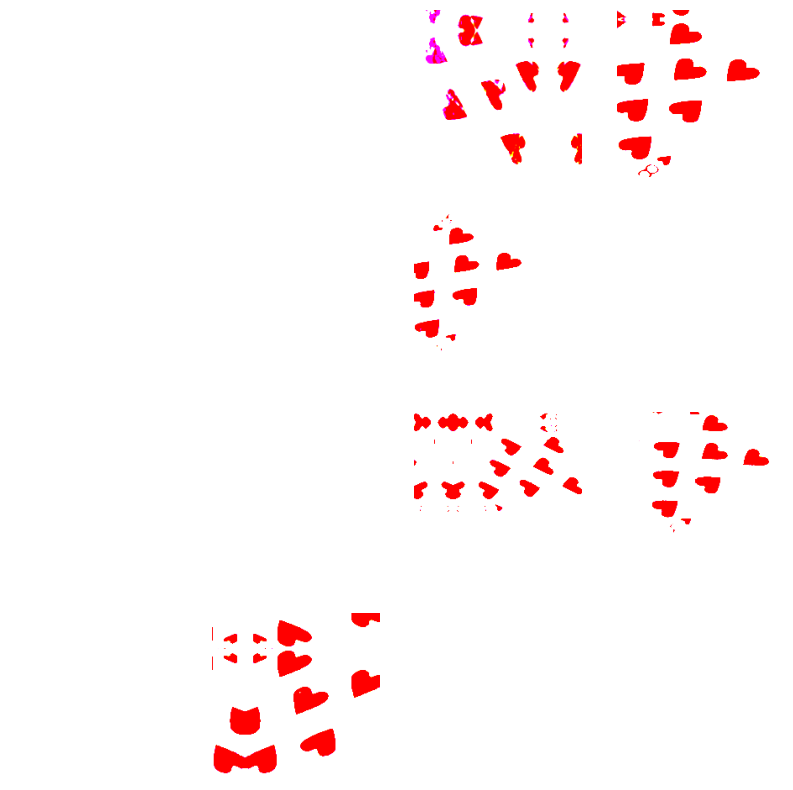

In [6]:
data_augmentation = Sequential([
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(factor=0.3),
    layers.RandomTranslation(height_factor=0.3, width_factor=0.3)
])


ex = next(iter(train_dataset_ReLU.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = data_augmentation(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

In [7]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, Dropout
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import GlobalAveragePooling2D



classes = train_dataset_ReLU.class_names
classes = np.array(classes)
shape = (*image_size, 3)
units_output = len(classes)
data_format = "channels_last"
scale = 1 / 255

model_ReLU = Sequential([
    layers.Input(shape=shape),  # Entrada explícita

    # Primera capa convolucional
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Tercera capa convolucional
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Cuarta capa convolucional
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Quinta capa convolucional
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Quinta capa convolucional
    layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Aplanar y densas
    layers.Flatten(data_format),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    layers.Dense(units_output, activation='softmax')  # Salida
])

# Optimizador y compilación
model_ReLU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model_ReLU.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 200, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 25, 25, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 6, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,838,389 (64.23 MB)

 Trainable params: 16,834,357 (64.22 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath="cnn_card_classification.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)
]

# Ajustar el entrenamiento con más épocas
history_ReLU = model_ReLU.fit(
    train_dataset_ReLU,
    epochs=100,  # Aumentamos el número de épocas
    validation_data=validation_dataset_ReLU,
    callbacks=callbacks
)

Epoch 1/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - accuracy: 0.0650 - loss: 7.4830 - val_accuracy: 0.2302 - val_loss: 5.6309 - learning_rate: 1.0000e-04
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.1855 - loss: 5.9011 - val_accuracy: 0.3509 - val_loss: 4.8429 - learning_rate: 1.0000e-04
Epoch 3/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.2714 - loss: 5.3342 - val_accuracy: 0.4453 - val_loss: 4.4184 - learning_rate: 1.0000e-04
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.3203 - loss: 4.9627 - val_accuracy: 0.4792 - val_loss: 4.1040 - learning_rate: 1.0000e-04
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.3907 - loss: 4.5816 - val_accuracy: 0.5925 - val_loss: 3.6401 - learning_rate: 1.0000e-04
Epoch 6/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.4842 - loss: 4.1617 - val_accuracy: 0.6453 - val_loss: 3.3989 - learning_rate: 1.0000e-04
Epoch 7/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 4

In [9]:
ev1 = model_ReLU.evaluate(test_dataset_ReLU)
print(ev1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9056 - loss: 0.9645
[1.1136835813522339, 0.8830188512802124]


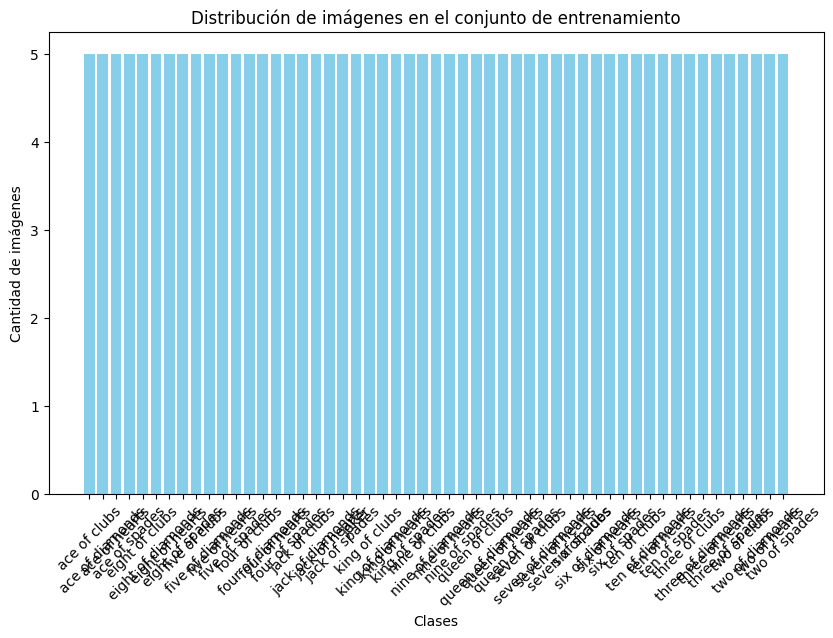

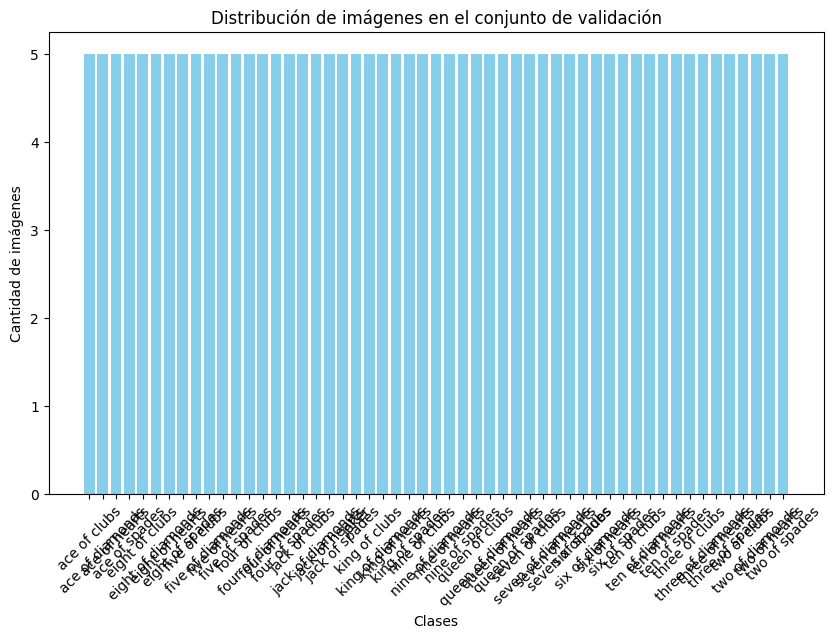

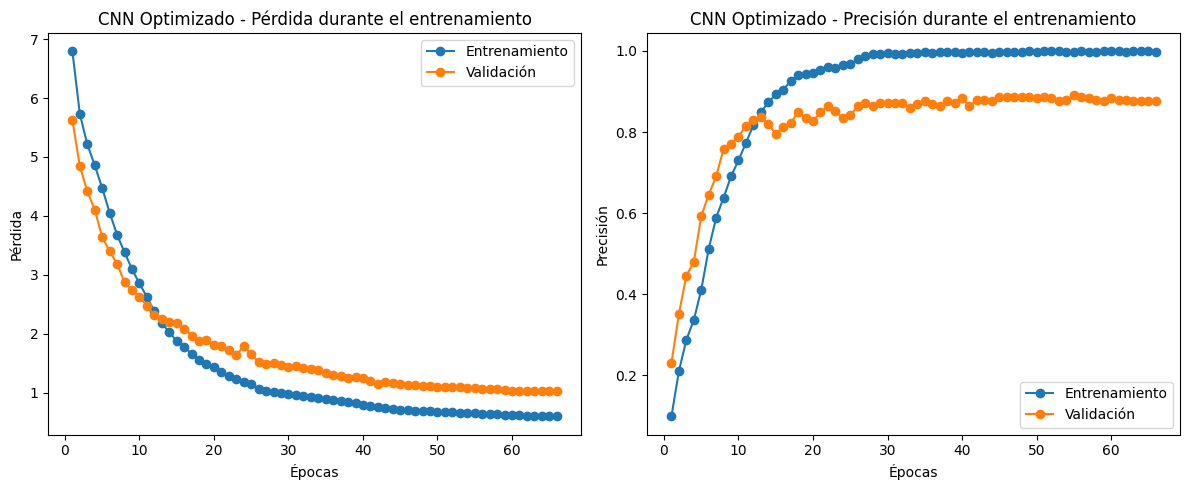

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


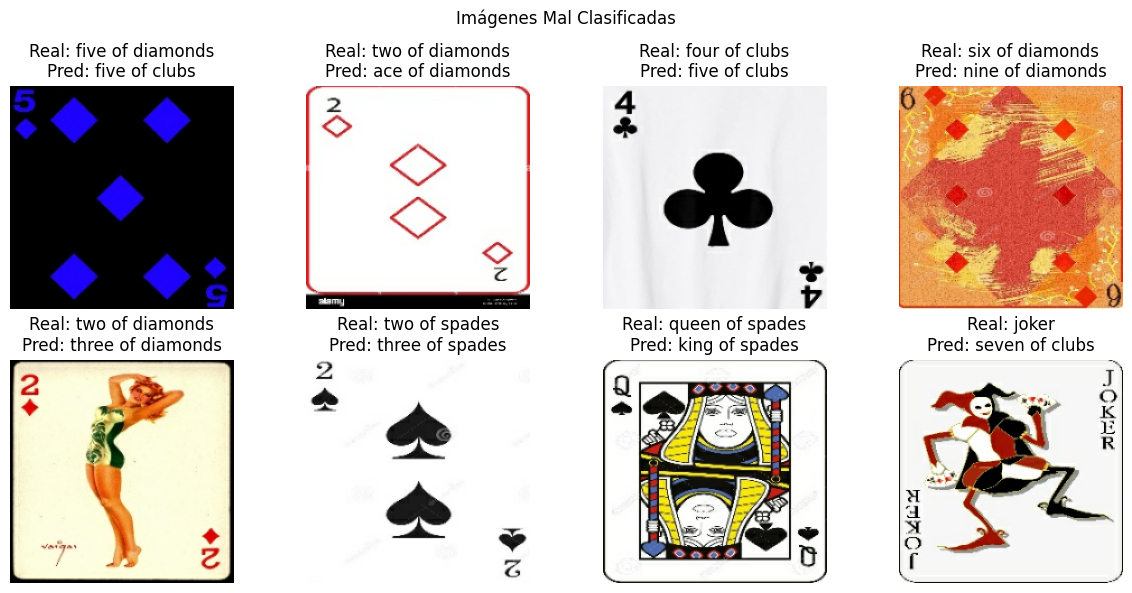

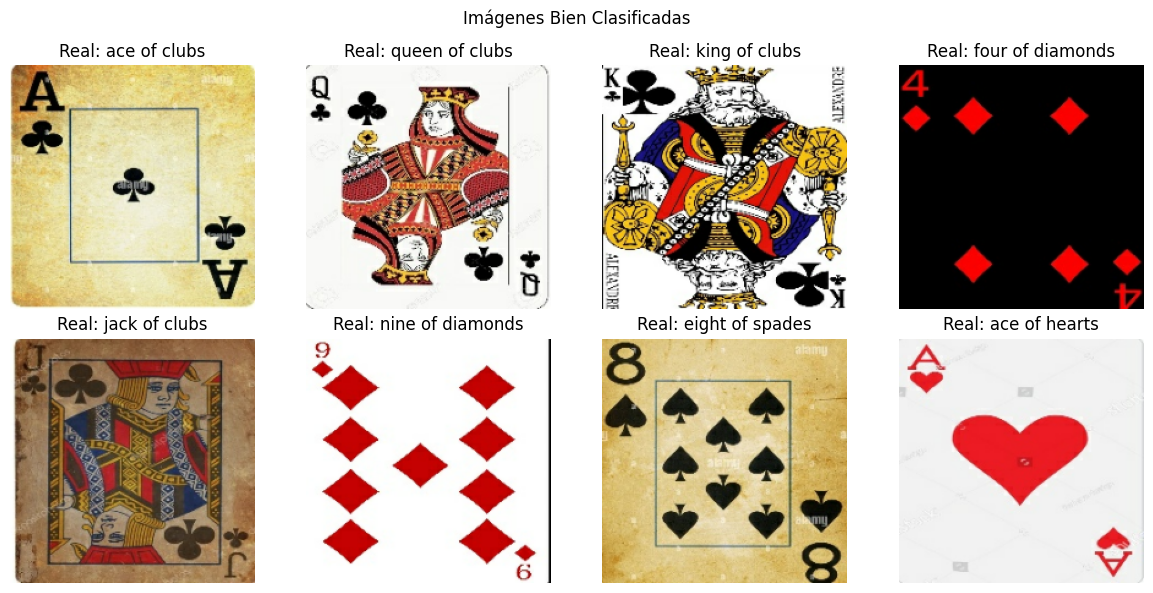

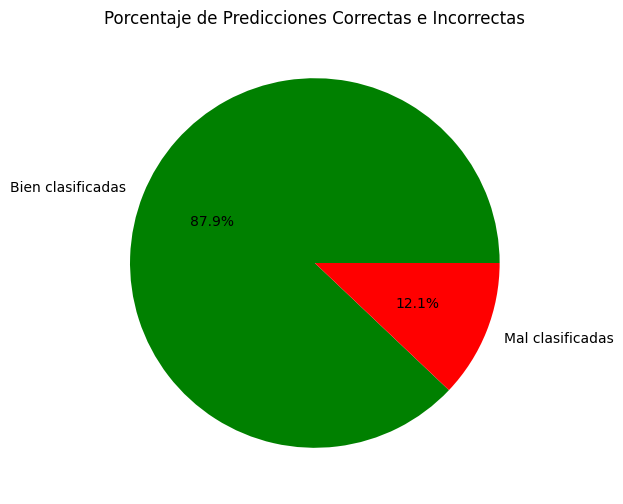


Estadísticas del Modelo CNN:

|       |   accuracy |      loss |   val_accuracy |   val_loss |   learning_rate |
|:------|-----------:|----------:|---------------:|-----------:|----------------:|
| count | 66         | 66        |      66        |  66        |    66           |
| mean  |  0.894323  |  1.52087  |       0.820983 |   1.75711  |     4.48145e-05 |
| std   |  0.210226  |  1.39157  |       0.128439 |   0.992608 |     4.39151e-05 |
| min   |  0.0983736 |  0.593902 |       0.230189 |   1.0231   |     1.6e-07     |
| 25%   |  0.928909  |  0.67702  |       0.831132 |   1.10083  |     4e-06       |
| 50%   |  0.995344  |  0.920019 |       0.871698 |   1.386    |     2e-05       |
| 75%   |  0.998164  |  1.63086  |       0.879245 |   1.94643  |     0.0001      |
| max   |  0.999606  |  6.79698  |       0.890566 |   5.63091  |     0.0001      |

Resumen de métricas acumuladas para todos los modelos:

       model_name  train_loss  val_loss  train_accuracy  val_accuracy  \
0  CNN Op

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model

# Variable global para almacenar los resultados de todos los modelos
model_metrics = []

# 1. Distribución de imágenes por clase
def plot_class_distribution(dataset, title):
    class_counts = {class_name: 0 for class_name in classes}

    for _, label in dataset.unbatch():
        label = int(label.numpy()) 
        class_counts[classes[label]] += 1

    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Clases")
    plt.ylabel("Cantidad de imágenes")
    plt.show()

# Distribución para entrenamiento y validación
plot_class_distribution(test_dataset_ReLU, "Distribución de imágenes en el conjunto de entrenamiento")
plot_class_distribution(validation_dataset_ReLU, "Distribución de imágenes en el conjunto de validación")

# 2. Curvas de pérdida y precisión
def plot_training_curves(history, model_name):
    epochs = range(1, len(history.history['loss']) + 1)

    # Guardar métricas en la lista global
    model_metrics.append({
        "model_name": model_name,
        "train_loss": history.history['loss'][-1],
        "val_loss": history.history['val_loss'][-1],
        "train_accuracy": history.history['accuracy'][-1],
        "val_accuracy": history.history['val_accuracy'][-1]
    })

    plt.figure(figsize=(12, 5))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'o-', label='Entrenamiento')
    plt.plot(epochs, history.history['val_loss'], 'o-', label='Validación')
    plt.title(f'{model_name} - Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Entrenamiento')
    plt.plot(epochs, history.history['val_accuracy'], 'o-', label='Validación')
    plt.title(f'{model_name} - Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llamar a la función para el modelo actual
plot_training_curves(history_ReLU, model_name="CNN Optimizado")

# 3. Predicciones bien y mal clasificadas
def analyze_predictions(model, dataset, num_images=8):
    images, labels = next(iter(dataset.unbatch().batch(1000)))
    labels = labels.numpy() 
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Filtrar bien y mal clasificadas
    correct_idx = np.where(predicted_classes == labels)[0]
    misclassified_idx = np.where(predicted_classes != labels)[0]

    # Mostrar imágenes mal clasificadas
    plt.figure(figsize=(12, 6))
    plt.suptitle("Imágenes Mal Clasificadas")
    for i in range(min(num_images, len(misclassified_idx))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[misclassified_idx[i]].numpy().astype('uint8'))
        plt.title(f"Real: {classes[labels[misclassified_idx[i]]]}\nPred: {classes[predicted_classes[misclassified_idx[i]]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Mostrar imágenes bien clasificadas
    plt.figure(figsize=(12, 6))
    plt.suptitle("Imágenes Bien Clasificadas")
    for i in range(min(num_images, len(correct_idx))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[correct_idx[i]].numpy().astype('uint8'))
        plt.title(f"Real: {classes[labels[correct_idx[i]]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Gráfico circular para bien y mal clasificadas
    correct_count = len(correct_idx)
    misclassified_count = len(misclassified_idx)
    plt.figure(figsize=(6, 6))
    plt.pie([correct_count, misclassified_count], labels=["Bien clasificadas", "Mal clasificadas"], autopct='%1.1f%%', colors=['green', 'red'])
    plt.title("Porcentaje de Predicciones Correctas e Incorrectas")
    plt.show()

    return correct_count, misclassified_count

# Analizar predicciones en el conjunto de validación
correct, misclassified = analyze_predictions(model_ReLU, validation_dataset_ReLU)

# Guardar los resultados de predicción en la lista global
model_metrics[-1]["correct_predictions"] = correct
model_metrics[-1]["misclassified_predictions"] = misclassified

# 4. Estadísticas descriptivas del modelo
history_df = pd.DataFrame(history_ReLU.history)
print("\nEstadísticas del Modelo CNN:\n")
print(history_df.describe().to_markdown(index=True))

# 5. Guardar resultados en un DataFrame
metrics_df = pd.DataFrame(model_metrics)

# Mostrar los resultados
print("\nResumen de métricas acumuladas para todos los modelos:\n")
print(metrics_df)